# **Introduction to In-Context Learning Demo: PID (Proportional-Integral-Derivative) Tuning**
This notebook presents a systematic demonstration of how Large Language Models (LLMs) can perform PID controller tuning through in-context learning (ICL). Motivated by recent advances in LLM-based numerical optimization, this experiment investigates whether providing Gemini with examples of suboptimally tuned controllers enables it to refine tuning parameters and improve closed-loop performance. Performance is quantified through three standard metrics: Mean Square Error (MSE) between the controlled variable ($y$) and setpoint ($r$), variance in the controlled variable ($y_{var}$), and variance in the manipulated variable ($u_{var}$).

The objective is to demonstrate that LLMs, when equipped with appropriate in-context examples, can iteratively reason through control design problems and function as effective control engineering assistants.

## **Tutorial Overview**

This interactive demonstration guides you through the following methodological steps:

1. **Controller Construction**: Implement three classical controller structures (PI, PID, PID with filter) for a first-order time-invariant dynamic system with delay.
2. **Example Curation**: Prepare representative tuning examples to facilitate in-context learning.
3. **Prompt Engineering**: Construct ICL prompts to instantiate a tuning assistant.
4. **Iterative Optimization**: Query the LLM (Gemini 2.0/2.5 Flash) to progressively refine controller parameters.

The resulting framework illustrates the potential of LLMs to serve as optimization assistants in control systems engineering.

---

# **Background**

This demonstration focuses on leveraging LLMs as optimizers for controller tuning. Before proceeding with the implementation, we establish the fundamental control problem and relevant theoretical background.

## **The Feedback Control Paradigm**

Control systems engineering addresses the automation of dynamic processes ($P$) to regulate controlled variables ($y(t) = P(u(t), d(t))$) to desired setpoints ($r(t)$) despite disturbances ($d(t)$). This is achieved by designing a controller ($C$) that manipulates process inputs ($u(t)$) to minimize tracking error $e(t) = r(t) - y(t)$. For this tutorial, we consider a feedback-only architecture with additive disturbances that do not affect process dynamics ($y(t) = P(u(t)) + d(t)$), as depicted below.

<p style="text-align:center;">
<img src="https://github.com/MohamedElMistiri/LLM-PID-Tuning-Demo/blob/main/images/closed-loop-block-diagram.png?raw=true" alt="Closed-loop feedback control block diagram" style="max-width: 600px;">
</p>

Controllers may take numerous forms, from classical PID to optimal control (LQR, MPC) or reinforcement learning policies. This tutorial focuses on PID variants as representative examples.

## **PID Controller Fundamentals**

PID controllers combine three control actions based on the error signal:

- **Proportional (P)**: Provides corrective action proportional to the instantaneous error
- **Integral (I)**: Eliminates steady-state offset by integrating historical error
- **Derivative (D)**: Anticipates future error trends through derivative action

The continuous-time representation is:

$$u(t) = C(e(t)) = K_c\left(e(t) + \frac{1}{\tau_I} \int_0^t e(\tau) d\tau + \tau_D \frac{de(t)}{dt}\right)$$

where $K_c$ is the proportional gain, $\tau_I$ the integral time constant, and $\tau_D$ the derivative time constant. The equivalent transfer function representation is:

$$C(s) = \frac{u(s)}{e(s)} = K_c\left(1 + \frac{1}{\tau_I s}  + \tau_D s \right)$$

This tutorial examines three PID architectures:

1. **PI Controller**: Proportional and integral actions only ($\tau_D = 0$). Two tunable parameters: $K_c$ and $\tau_I$.
2. **PID Controller**: Full three-term implementation. Three tunable parameters: $K_c$, $\tau_I$, and $\tau_D$.
3. **PID with Filter (PIDwF)**: Includes a first-order filter on the error signal to attenuate high-frequency noise and render the derivative term physically realizable:
$$C(s) = K_c\left(1 + \frac{1}{\tau_I s}  + \tau_D s \right) \left(\frac{1}{\tau_F s + 1}\right)$$ This formulation introduces a fourth tuning parameter, the filter time constant $\tau_F$.

## **Process Model: First-Order System**

We evaluate controller performance on a first-order linear time-invariant system:

$$\tau\frac{dy(t)}{dt} + y(t) = k_p u(t)$$

This ordinary differential equation describes numerous physical processes, where $\tau$ is the system time constant (response speed) and $k_p$ is the steady-state gain (input-output sensitivity). The transfer function representation is:

$$P(s) = \frac{y(s)}{u(s)} = \frac{k_p}{\tau s + 1}$$

To concretize these representations, consider the following canonical examples from each engineering domain:

### **1. Thermal System: Room Temperature Dynamics**

Energy balance for a room with thermal capacitance $C_{th}$ and resistance $R_{th}$:

$$C_{th}\frac{dT_{room}(t)}{dt} = \dot{Q}_{heater}(t) - \frac{T_{room}(t) - T_{amb}}{R_{th}}$$

In standard form with $y(t) = T_{room}$ and $u(t) = \dot{Q}_{heater}$:

$$\tau\frac{dT_{room}(t)}{dt} + T_{room}(t) = k_p u(t) + T_{amb}$$

**Parameters:**
- $\tau = R_{th}C_{th}$ [minutes]: Thermal time constant
- $k_p = R_{th}$ [°C/kW]: Steady-state temperature rise per unit heating power
- $T_{amb}$ [°C]: Ambient temperature (disturbance)
- $T_{room}$ [°C]: Room temperature (controlled variable)

**Laplace domain (deviation variables):**

$$P(s) = \frac{T_{room}(s)}{\dot{Q}_{heater}(s)} = \frac{k_p}{\tau s + 1}$$

### **2. Electrical System: RC Low-Pass Filter**

Series RC circuit with input voltage $V_{in}(t)$ and output voltage $V_{out}(t)$ across the capacitor:

$$RC\frac{dV_{out}(t)}{dt} + V_{out}(t) = V_{in}(t)$$

**Parameters:**
- $R$ [Ω]: Resistance
- $C$ [F]: Capacitance
- $\tau = RC$ [seconds]: Electrical time constant
- $k_p = 1$ [V/V]: Unity gain

**Transfer function:**

$$P(s) = \frac{V_{out}(s)}{V_{in}(s)} = \frac{1}{\tau s + 1}$$

### **3. Mechanical System: Velocity of Mass-Damper System**

Mass $m$ moving with velocity $v(t)$ under applied force $F(t)$ and viscous friction coefficient $b$:

$$m\frac{dv(t)}{dt} + bv(t) = F(t)$$

In standard form:

$$\tau\frac{dv(t)}{dt} + v(t) = k_p F(t)$$

**Parameters:**
- $\tau = m/b$ [seconds]: Mechanical time constant
- $k_p = 1/b$ [(m/s)/N]: Steady-state velocity per unit force
- $v(t)$ [m/s]: Velocity (controlled variable)
- $F(t)$ [N]: Applied force (manipulated variable)

**Laplace domain:**

$$P(s) = \frac{v(s)}{F(s)} = \frac{k_p}{\tau s + 1}$$

### **4. Chemical System: Liquid Level in Cylindrical Tank**

Cylindrical tank of cross-sectional area $A$ with inlet flow $Q_{in}(t)$ and outlet flow proportional to hydrostatic head:

$$A\frac{dh(t)}{dt} = Q_{in}(t) - k_{out}h(t)$$

In standard form:

$$\tau\frac{dh(t)}{dt} + h(t) = k_p Q_{in}(t)$$

**Parameters:**
- $A$ [m²]: Tank cross-sectional area
- $k_{out}$ [m²/s]: Outlet flow coefficient
- $\tau = A/k_{out}$ [seconds]: Hydraulic time constant
- $k_p = 1/k_{out}$ [m/(m³/s)]: Steady-state level per unit inlet volumtric flow
- $h(t)$ [m]: Liquid level (controlled variable)
- $Q_{in}(t)$ [m³/s]: Inlet flow rate (manipulated variable)

**Transfer function:**

$$P(s) = \frac{h(s)}{Q_{in}(s)} = \frac{k_p}{\tau s + 1}$$

These diverse physical systems share an identical mathematical structure, underscoring the universal applicability of first-order system analysis and controller design methodology.

### **5. Incorporating Time Delay**

The preceding examples represent idealized dynamics. Physical systems often exhibit **time delay** (dead time, $\theta$) due to transport phenomena, measurement latency, or computational lag. This delay between applying a control action and observing its effect significantly complicates tuning and is a critical consideration in practice.

The time-delayed first-order system becomes:

$$\tau\frac{dy(t)}{dt} + y(t) = k_p \, u(t-\theta)$$

In the Laplace domain, delay introduces an irrational exponential term:

$$P(s) = \frac{y(s)}{u(s)} = \frac{k_p}{\tau s + 1} e^{-\theta s}$$

This tutorial includes time delay as a tunable parameter to reflect realistic process dynamics and assess the LLM's ability to handle this added complexity.

---

# **LLM-Guided PID Tuning via In-Context Learning**

This demonstration frames PID tuning as an optimization problem solved through iterative LLM interaction. The approach leverages in-context learning to transform the language model into a control engineering assistant capable of reasoning about parameter selection and closed-loop performance.

## **Methodology**

The tuning workflow proceeds as follows:

1. **Initialization**: Provide the LLM with two in-context examples comprising randomly generated PID parameters and their corresponding performance metrics (MSE, output variance, and input variance) from closed-loop simulations.

2. **Generation**: The LLM proposes a new set of tuning parameters, accompanied by explicit reasoning for its recommendations.

3. **Evaluation**: The suggested parameters are implemented in a closed-loop simulation, generating updated performance metrics.

4. **Iteration**: The simulation results are appended to the prompt history, creating an enriched context for subsequent LLM queries. This feedback loop continues until either the MSE converges to a minimum or a predefined iteration limit is reached.

## **Performance Assessment**

To contextualize the LLM-tuned controller performance, we benchmark results against the Internal Model Control (IMC) tuning method—a well-established model-based approach that derives PID parameters directly from process characteristics (time constant, gain, and time delay). IMC provides a theoretically grounded baseline for evaluating the efficacy of LLM-driven optimization. For a comprehensive treatment of IMC tuning principles, refer to [Rivera et al. (1986)](https://skoge.folk.ntnu.no/publications/1986/Rivera86/Rivera86.pdf).

This comparative framework enables quantitative assessment of whether in-context learning can achieve performance comparable to traditional model-based tuning while requiring only minimal process knowledge and no explicit optimization algorithms.

## **Code Overview**

The implementation is organized into a modular structure, with each component responsible for a different stage of the PID tuning pipeline. This design separates system configuration, closed-loop simulation, prompt construction, LLM inference, and performance evaluation, making the system easy to understand, modify, and extend for different process dynamics or controller types.

In [ ]:
#@title **Install ```control``` mondule**
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 18.8 MB/s eta 0:00:00


In [ ]:
#@title **Import Necessary Libraries**

import control as ct
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import dotenv
import datetime
import json
from google import genai
import time
import re
import getpass
import ipywidgets as widgets

## **Before Running the Demo, Follow the Instructions Below**
To run the full experiment:
1. Ensure all dependencies are imported and installed.
2.	Visit Google AI Studio (https://aistudio.google.com/) to obtain your Gemini API key.
3.	Once API key is generated, copy and paste it into the demo when prompted.

#### **If having trouble creating an API Key, follow the link below for instructions:**
* #### **[Instructions on How to Obtain a Gemini API Key](https://docs.google.com/document/d/17pgikIpvZCBgcRh4NNrcee-zp3Id0pU0vq2SG52KIGE/edit?usp=sharing)**



In [ ]:
#@title **Setting Up Gemini Client**
apikey = getpass.getpass("Enter your Gemini API Key: ")

Enter your Gemini API Key: ··········


In [ ]:
#@title **Choose a Model**
model_dropdown = widgets.Dropdown(
    options=[
        ("Gemini 2.5 Flash", "gemini-2.5-flash"),
        ("Gemini 2.0 Flash", "gemini-2.0-flash")
    ],
    description="Model:",
    value="gemini-2.5-flash",
    style={'description_width': 'initial'}
)

confirm_button = widgets.Button(
    description="Confirm Selection"
)

output = widgets.Output()

model_name = None

def on_confirm_click(b):
    global model_name, batch_size

    model_name = model_dropdown.value

    with output:
        output.clear_output()
        print(f"\nSelected model: {model_name}")

confirm_button.on_click(on_confirm_click)

display(model_dropdown, confirm_button, output)

Dropdown(description='Model:', options=(('Gemini 2.5 Flash', 'gemini-2.5-flash'), ('Gemini 2.0 Flash', 'gemini…

Button(description='Confirm Selection', style=ButtonStyle())

Output()

# **Utility Functions**

**Response Parser**  
Extracts numerical parameter values from the LLM's textual output, converting recommendations like "$K_c$ = 2.5, $\tau_I$ = 15.2" into an ordered list of floats for direct simulation use.

**Performance Metric: MSE**  
Computes the mean squared error between the setpoint trajectory and controlled variable output, serving as the primary optimization objective that guides the LLM's tuning iterations.

**Example Formatter**  
Generates a structured text string that encapsulates a tuning attempt's parameters (e.g., $K_c$, $\tau_I$) and resulting performance metrics (MSE, output variance, input variance) for inclusion in the LLM's prompt history.

**Data Persistence**  
Saves the complete experimental record—comprising parameters, metrics, and LLM responses at each iteration—to a JSON file for post-analysis and reproducibility

In [ ]:
#@title **Utility Functions**
def parse_response(input_text):
    """Extract all numbers from a string as floats."""
    pattern = r"[-+]?\d+(?:\.\d+)?"
    return [float(match) for match in re.findall(pattern, input_text)]

def calculate_mse(x, y):
    """Mean squared error between two arrays."""
    return np.mean((x - y)**2)

def generate_example_str(params, mse, i, y_var, u_var):
    """Generalized example string for any controller type."""
    param_str = ', '.join([f"{k} = {v}" for k, v in params.items()])
    return f"Example {i}: Tuning Parameters: {param_str}, produced an error of: MSE = {mse}, output variance: {y_var}, manipulated variable variance: {u_var}"

def save_json(data, filename):
    """Save data to a JSON file safely, even if it contains non-serializable objects like 'Content'."""
    def default_serializer(obj):
        # Try to convert known object types to a serializable form
        if hasattr(obj, "__dict__"):
            return obj.__dict__  # convert custom objects to dict
        return str(obj)  # fallback to string

    with open(filename, 'w') as f:
        json.dump(data, f, default=default_serializer, indent=2)

## **Controller Configuration**

This function calculates baseline tuning parameters using the Internal Model Control (IMC) method—a classic, proven approach that derives controller settings directly from your process characteristics. Think of IMC as the "traditional expert" whose performance we'll compare against our AI assistant.

The function supports three controller types:
- **PI**: Two parameters for basic control (proportional + integral)
- **PID**: Three parameters for more aggressive control (adds derivative action)
- **PIDwFilter**: Four parameters that include a noise-filtering term for smoother operation

You simply specify which controller you want (via `case`), provide your process model values (time constant `tau`, gain `kp`, and delay `theta`), and the function returns scientifically-grounded parameters that serve as both a starting point and performance benchmark for the LLM optimization.

In [ ]:
#@title **Controller Configuration**
def get_controller_params(case, alpha, tau, theta, kp):
    """Return controller parameters and names for PI, PID, or PIDf."""
    lamb = alpha * (tau + 0.5 * theta)
    if case == 1:  # PI
        params = dict(Kc=(2*tau+theta)/(kp*2*lamb),
                      tau_I=tau + theta/2,
                      tau_D=0,
                      tau_F=0)
        names = ['Kc', 'tau_I']
        label = "PI"
    elif case == 2:  # PID
        params = dict(Kc=(2*tau+theta)/(kp*(2*lamb+theta)),
                      tau_I=tau + theta/2,
                      tau_D=(tau*theta)/(2*tau+theta),
                      tau_F=0.01)
        names = ['Kc', 'tau_I', 'tau_D']
        label = "PID"
    elif case == 3:  # PIDwfilter
        params = dict(Kc=(2*tau+theta)/(kp*(2*lamb+2*theta)),
                      tau_I=tau + theta/2,
                      tau_D=(tau*theta)/(2*tau+theta),
                      tau_F=(lamb*theta)/(2*lamb+2*theta))
        names = ['Kc', 'tau_I', 'tau_D', 'tau_F']
        label = "PIDwfilter"
    return params, names, label

<!-- ## **Closed-Loop Simulation**

This function is the experimental testbed where we evaluate how well a given set of PID parameters actually controls our process. Think of it as a virtual laboratory: we build a digital twin of our real-world system, connect our controller to it, run through realistic scenarios, and measure the results.

**Here's what happens, step by step:**

**1. Build the Plant Model**  
We create a mathematical representation of our process (like a heater, motor, or tank) using its key characteristics: gain (`kp`) and time constant (`tau`). This is the "thing" we're trying to control.

**2. Add Real-World Delay**  
Physical systems don't respond instantly. We model the transport delay (`theta`)—the time between taking an action and seeing its effect—using a Padé approximation. This makes our simulation much more realistic.

**3. Assemble the Controller**  
We construct the PID controller as a transfer function using the tuning parameters (`Kc`, `tau_I`, `tau_D`, `tau_F`). This is the "brain" that will make decisions.

**4. Wire Everything Together**  
We connect the plant, controller, and disturbance signals into a complete **feedback loop**: the controller reads the error (difference between desired and actual output), calculates a corrective action, applies it to the plant, and the cycle continues. We also add a summing junction to inject disturbances.

**5. Create Test Scenarios**  
We generate realistic test signals:
- A **setpoint change** at time `t_setpoint` (e.g., "increase room temperature to 22°C")
- A **disturbance** at time `t_disturbance` (e.g., someone opens a window)

**6. Run the Virtual Experiment**  
The simulation calculates how the system behaves every millisecond over the time horizon, showing us exactly how the controlled variable (`y`) and manipulated variable (`u`) respond.

**7. Measure Performance**  
We compute three critical metrics:
- **Mean Squared Error (MSE)**: How far did the actual output drift from the setpoint? Lower is better.
- **Output Variance (`y_var`)**: How steady was the controlled variable? We want smooth, not oscillatory.
- **Input Variance (`u_var`)**: How aggressively did the controller act? We want efficient control, not "jumpy" actuator movements.

**8. Optional Visualization**  
If requested, we plot the time trajectories of both the process variable and controller output so you can literally *see* how the system behaves.

**What you get back**: The function returns all performance metrics plus the full time-series data (`response`), giving us everything needed to evaluate whether the LLM's suggested parameters are actually improving control. -->
## **Closed-Loop Simulation Module**

This function constitutes the core computational framework for evaluating controller performance. It constructs a complete feedback control system in the Laplace domain, simulates its dynamic response to realistic operational scenarios, and quantifies performance through standardized metrics.

**The simulation proceeds through four primary phases:**

**1. Process Model Assembly**  
The function first defines the plant dynamics as a first-order transfer function characterized by process gain (`kp`) and time constant (`tau`). To capture real-world behavior, transport delay (`theta`) is incorporated via a 20th-order Padé approximation, ensuring high-fidelity representation of latency effects inherent in physical systems.

**2. Controller Realization**  
The PID control law is implemented as a transfer function using the provided tuning parameters. The general structure accommodates proportional, integral, and derivative actions, with an optional first-order filter (`tau_F`) for derivative term noise attenuation. This flexible formulation supports PI, PID, and filtered-PID configurations through a unified implementation.

**3. Closed-Loop System Construction**  
The plant, controller, and disturbance injection pathways are integrated into a complete feedback architecture using `control.InterconnectedSystem`. This creates a rigorous mathematical representation where:
- The controller acts on measured error (setpoint minus process output)
- Control actions propagate through the delayed plant dynamics
- Additive disturbances can be injected at the plant input
- Both controlled and manipulated variables are accessible for analysis

**4. Performance Evaluation**  
The system undergoes forced-response simulation through a standardized test protocol:
- **Setpoint step**: A reference change at `t_setpoint` evaluates tracking performance
- **Disturbance step**: A load disturbance at `t_disturbance` assesses regulatory capability

Performance is rigorously quantified via three complementary metrics:
- **Mean Squared Error (MSE)**: Aggregated tracking accuracy during both transient and steady-state phases
- **Output Variance**: Statistical dispersion of the controlled variable, indicating oscillation tendency
- **Input Variance**: Statistical dispersion of the manipulated variable, reflecting control effort and actuator wear

When visualization is enabled, the function generates time-domain trajectories of both controlled and manipulated variables, providing intuitive insight into closed-loop behavior. The complete time-series data and performance metrics are returned, enabling downstream analysis and iterative optimization.

In [ ]:
#@title **Simulation**
def closed_loop_simulation(config):
    """Run closed-loop simulation and return performance metrics."""
    num = [config['kp']]
    den = [config['tau'], 1]
    plant = ct.TransferFunction(num, den, name="plant", inputs="u", outputs="y")
    delay_num, delay_den = ct.pade(config['theta'], 20)
    delay_tf = ct.TransferFunction(delay_num, delay_den)
    plant_delayed = plant * delay_tf
    plant_delayed.name = "plant"

    controller_num = [config['Kc']*config['tau_I']*config['tau_D'],
                      config['Kc']*config['tau_I'],
                      config['Kc']]
    controller_den = [config['tau_I']*config['tau_F'],
                      config['tau_I'],
                      0]
    controller = ct.TransferFunction(controller_num, controller_den, name="controller", inputs="y", outputs="u")
    add_disturbance = ct.summing_junction(inputs=['u', 'd'], output="u")
    add_disturbance.name = "add_disturbance"
    cl_sys = ct.InterconnectedSystem(
        [plant_delayed, controller, add_disturbance], name="cl_sys",
        connections=[
            ["controller.y", "-plant.y"], ["add_disturbance.u", "controller.u"],
            ["plant.u", "add_disturbance.u"]
        ],
        inplist=["controller.y", "add_disturbance.d"],
        inputs=["y_ref", "d"],
        outlist=["plant.y", "controller.u"],
        outputs=["y", "u"]
    )

    Ts = config['t_end'] / config['n_samples']
    T = np.linspace(config['t_start'], config['t_end'], config['n_samples'])
    y_ref = np.zeros(T.shape)
    n_setpoint = int(config['t_setpoint'] / Ts)
    y_ref[n_setpoint:] = config['setpoint']
    d = np.zeros(T.shape)
    n_disturbance = int(config['t_disturbance'] / Ts)
    d[n_disturbance:] = config['disturbance']

    response = ct.forced_response(cl_sys, T, [y_ref, d])

    if config.get('plot_results', False):
        plt.figure()
        plt.subplot(211)
        plt.plot(response.t, response.y[0], label="controlled variable (y)")
        plt.plot(response.t, response.u[0], linestyle='--', label="setpoint (r)")
        plt.xlim((response.t[0], response.t[-1]))
        plt.grid(True)
        plt.ylabel('y')
        plt.legend()
        plt.subplot(212)
        plt.plot(response.t, response.y[1], label='manipulated variable ($u$)')
        plt.plot(response.t, response.u[1], linestyle='--', label='disturbance (d)')
        plt.xlim((response.t[0], response.t[-1]))
        plt.ylim([-2, 2])
        plt.grid(True)
        plt.ylabel('u')
        plt.xlabel('Time [s]')
        plt.legend()
        plt.show()

    setpoint_tracking_mse = calculate_mse(response.y[0][n_setpoint:n_disturbance], response.u[0][n_setpoint:n_disturbance])
    disturbance_rejection_mse = calculate_mse(response.y[0][n_disturbance:], response.u[0][n_disturbance])
    mse_overall = calculate_mse(response.y[0], response.u[0])
    y_var = np.var(response.y[0][n_setpoint:])
    u_var = np.var(response.y[1][n_setpoint:])
    return setpoint_tracking_mse, disturbance_rejection_mse, mse_overall, y_var, u_var, response

## **LLM Interaction and Iterative Optimization Module**

This function serves as the orchestration layer for the in-context learning workflow, managing the conversational state with Gemini and driving the iterative parameter refinement process. It transforms the language model into an active participant in the control design optimization, rather than a static advisor.

**The function executes a structured iterative protocol:**

**1. Conversation Initialization**  
Establishes a persistent chat session with the Gemini model, sending the initial ICL prompt that contains:
- Controller tuning objectives and constraints
- Representative examples of suboptimal parameters with their performance metrics
- Explicit formatting requirements for parameter extraction

**2. Iterative Refinement Loop**  
For each iteration, the system:
- **Parses** the LLM's response to extract numerical parameter recommendations using regex pattern matching
- **Updates** the simulation configuration with the proposed tuning values
- **Evaluates** the new parameters through the closed-loop simulation, yielding objective performance metrics (MSE, variances)
- **Enriches context** by appending the empirical results to the conversation history via the iteration prompt template
- **Re-queries** the LLM, now armed with additional performance data to inform subsequent recommendations

This creates a feedback loop where each iteration's outcomes become in-context examples for the next, enabling the model to learn from its own suggestions' successes and failures.

**3. Exception Handling and Resilience**  
The loop incorporates robust error handling: if parameter parsing fails or simulation errors occur, the system logs the exception, implements a cooldown period (60-second sleep), and continues the optimization process rather than terminating abruptly.

**4. Termination and Documentation**  
Upon reaching `max_iterations`, the function performs a final evaluation of the LLM's last recommendation and requests a concluding response. It returns:
- **Complete conversation history**: Full transcript of the LLM's reasoning trajectory
- **Evaluation archive**: Time-series record of all parameter sets and their associated performance metrics
- **Final simulation response**: Time-domain data from the ultimate controller configuration for comparative visualization

This architecture enables systematic exploration of the LLM's ability to navigate the parameter space through linguistic reasoning, transforming controller tuning from a numerical optimization problem into a conversational design process, combining linguistic and numerical reasoning.

In [ ]:
#@title **Gemini Interaction**
def prompt_gemini(prompt, iteration_prompt, max_iterations, config, param_names):
    """Interact with Gemini for iterative controller tuning."""
    client = genai.Client(api_key=apikey)
    chat_session = client.chats.create(model=model_name)
    print("\n\nGemini is prompted")
    response = chat_session.send_message(prompt)
    res = parse_response(response.text)
    evaluations = []
    for iteration in range(max_iterations):
        try:
          if iteration == 0:
            print("Initiation prompt response:")
            print(response.text)
          else:
            print(f"Iteration {iteration-1} response:")
            print(response.text)
          # Update parameters based on the response
          for idx, name in enumerate(param_names):
              config[name] = res[idx]
          config["plot_results"] = False
          _, _, mse_overall_, y_var_, u_var_, _ = closed_loop_simulation(config)
          print(f"iteration {iteration}: " + ", ".join([f"{name} = {config[name]}" for name in param_names]) +
                f", mse = {mse_overall_}, y_var = {y_var_}, u_var = {u_var_}\n\n")
          evaluations.append([config[name] for name in param_names] + [mse_overall_, y_var_, u_var_])
          response = chat_session.send_message(
              iteration_prompt.format(i=iteration, **{name: config[name] for name in param_names},
                                      MSE=mse_overall_, y_var=y_var_, u_var=u_var_))
          res = parse_response(response.text)
        except Exception as e:
            print("Error:", e)
            time.sleep(60)
    # Final evaluation
    for idx, name in enumerate(param_names):
        config[name] = res[idx]
    config["plot_results"] = False
    _, _, mse_overall_, y_var_, u_var_, response_llm = closed_loop_simulation(config)
    evaluations.append([config[name] for name in param_names] + [mse_overall_, y_var_, u_var_])
    print(f"Iteration {iteration} response:")
    print(response.text)
    print(f"iteration {iteration+1}: " + ", ".join([f"{name} = {config[name]}" for name in param_names]) +
                f", mse = {mse_overall_}, y_var = {y_var_}, u_var = {u_var_}\n\n")
    return chat_session.get_history(), evaluations, response_llm

In [ ]:
#@title **Plotting Results**
def plot_results(evaluations, param_names, imc_params, mse_overall, y_var, u_var, save_directory, model_label, d):
    """Generalized plotting for controller parameters and performance."""
    n_params = len(param_names)
    plt.figure()
    for i, name in enumerate(param_names):
      if "tau" in name:
        name = "\\" + name
      plt.subplot(n_params, 1, i+1)
      plt.plot(range(len(evaluations)), np.array(evaluations)[:,i], label=f"${name}$")
      plt.axhline(imc_params[i], color='r', linestyle='--', label="IMC tuning")
      plt.xlim((0, len(evaluations)-1))
      plt.grid(True)
      plt.legend()
      plt.ylabel(f"${name}$")
      plt.xlabel("Iteration")
    plt.savefig(f"./Results/{save_directory}/{model_label}-tuning_parameters-max-iterations-{len(evaluations)}-{d}.png")
    plt.show()

    plt.figure()
    plt.subplot(211)
    plt.plot(range(len(evaluations)), np.array(evaluations)[:,n_params])
    plt.axhline(mse_overall, color='r', linestyle='--', label="IMC tuning")
    plt.xlim((0, len(evaluations)-1))
    plt.grid(True)
    plt.legend()
    plt.ylabel("Mean Squared Error (MSE)")
    plt.subplot(212)
    plt.plot(range(len(evaluations)), np.array(evaluations)[:,n_params+1], label='$y_{var}$')
    plt.plot(range(len(evaluations)), np.array(evaluations)[:,n_params+2], linestyle="--", label='$u_{var}$')
    plt.xlim((0, len(evaluations)-1))
    plt.axhline(u_var, color='g', label="$u_{var}$ IMC tuning")
    plt.axhline(y_var, color='r', linestyle='--', label="$y_{var}$ IMC tuning")
    plt.grid(True)
    plt.legend()
    plt.ylabel("variance")
    plt.xlabel("Iteration")
    plt.savefig(f"./Results/{save_directory}/{model_label}-performance-max-iterations-{len(evaluations)}-{d}.png")
    plt.show()

<style>
pre {
  white-space: pre-wrap;       /* Wrap long lines */
  word-wrap: break-word;       /* Break long words */
  overflow-x: auto;            /* Optional: allow horizontal scroll if needed */
}
</style>

## **Experiment Implementation: End-to-End LLM Tuning Workflow**

This is the master control function that coordinates the entire in-context learning experiment from initialization through final analysis. It systematically executes each phase of the comparative study, pitting the LLM's iterative reasoning against classical IMC tuning.

**The workflow consists of seven sequential stages:**

**1. Baseline Establishment**  
The function first generates IMC tuning parameters using the `get_controller_params` function. It then executes a closed-loop simulation with these IMC parameters, creating a performance benchmark measured through MSE, output variance, and input variance. This establishes the "gold standard" that the LLM must meet or exceed.

**2. In-Context Example Generation**  
To prime the LLM for effective learning, the function initiates two deliberately suboptimal tuning examples. These cases, featuring conservative and aggressive parameter choices, are simulated to produce their corresponding performance metrics. The examples are formatted into natural language descriptions that become the foundation of the ICL prompt, essentially teaching the LLM "what not to do" before it begins optimization.

**3. Prompt Engineering Architecture**  
The function maintains a dictionary of controller-specific prompt templates for PI, PID, and PIDwF variants. Each template is carefully engineered to:
- Establish the LLM's persona as a "smart and resourceful control systems engineer"
- Define explicit optimization objectives and parameter constraints
- Specify mandatory response formatting for reliable parsing
- Embed the suboptimal examples as contextual grounding

**Crucially, we intentionally refrain from passing the true model parameters (`kp`, `tau`, `theta`) to the LLM in our prompt.** This deliberate omission ensures that the LLM's tuning recommendations emerge purely from iterative in-context learning and performance feedback, rather than leveraging its nascent knowledge of classical control theory or pre-existing tuning rules. The LLM must discover effective parameter relationships through conversational reasoning alone.

**Prompt Example**

*Initiation Prompt:*

```
You are a smart and resourceful control systems engineer helping me tune a PID controller to minimize the Mean Squared
Error (MSE) between the controlled output variable (y) and the reference (r). The plant system to control is a first-order
system with a transport delay. The controller in use is PID controller with three tuning parameters (Kc, tau_I, tau_D).
Your goal is to adjust the tuning parameters: Kc in range {Kc_range}, tau_I in range {tau_I_range}, and tau_D in
range {tau_D_range} to minimize the MSE, as well as variance in the output controlled variable and the manipulated variable.
Next, you will see examples of the tuning parameters (Kc, tau_I, tau_D) and their corresponding MSE values.
    
Based on MSE and
variance values, please provide a new set of tuning parameters you think will help in minimizing the MSE and reduce variance
in both the manipulated and output variables.
You will provide your response in the following exact format:
    * new tuning parameters (Kc, tau_I, tau_D) aiming to minimize the mean square error.
    * a brief (one sentence) explanation of why you chose that input, considering the current iteration.
    
Here are the examples:
{examples}

```

*Iteration Prompt:*
```
iteration {i}:\n\nTuning Parameters: Kc = {Kc}, tau_I = {tau_I}, tau_D = {tau_D} produced an error of: MSE = {MSE},
output variance: y_var = {y_var}, manipulated variable variance: u_var = {u_var}

Based on the MSE value, please provide a new set of tuning parameters to minimize the MSE.
Please provide the results in the indicated format. Do not provide any additional texts.

```
**4. Parameter Space Definition**  
For each controller type, permissible ranges for each tuning parameter are codified. These bounds prevent the LLM from proposing physically unrealistic values (e.g., negative time constants) while granting sufficient freedom for meaningful exploration.

**5. Iterative Optimization Execution**  
The prepared prompt, iteration template, and configuration are passed to the `prompt_gemini` function, initiating the LLM-based optimization loop. This starts the iterative LLM interactions for the prescribed number of iterations.

**6. Persistent Data Archival**  
All experimental results are systematically preserved in timestamped JSON files within a dedicated `./Results/` directory structure:
- **Conversation transcripts**: Complete LLM dialogue including reasoning, parameter justifications, and decision-making rationale
- **Performance trajectories**: Per-iteration metrics capturing the optimization path and convergence behavior

This ensures full reproducibility and enables detailed post-hoc analysis of the LLM's reasoning process.

**7. Comparative Visualization**  
The function culminates by generating comparitive plots, overlaying the IMC and LLM-tuned controller responses in the same figure. It also delegates to the `plot_results` function for parameter convergence analysis, producing comprehensive figures that intuitively demonstrate whether LLM-based optimization can match or surpass traditional model-based tuning.

This modular structure ensures that each experimental run is self-contained, reproducible, and yields comprehensive documentation of both the LLM's reasoning process and its quantitative performance outcomes.

In [ ]:
#@title **Main Experiment Loop**
# --- Main Experiment Loop ---
def run_experiment(case, alpha, tau, theta, kp, t_start, t_end, n_samples,
                   t_setpoint, setpoint, t_disturbance, disturbance, max_iterations):
    params, param_names, controller_type = get_controller_params(case, alpha, tau, theta, kp)
    config = dict(
        kp=kp, tau=tau, theta=theta,
        t_start=t_start, t_end=t_end, n_samples=n_samples,
        t_setpoint=t_setpoint, setpoint=setpoint,
        t_disturbance=t_disturbance, disturbance=disturbance,
        plot_results=True, **params
    )
    print("********************* Baseline: IMC Tuning *********************")
    print("IMC params:", [(name, params[name]) for name in param_names])
    setpoint_tracking_mse, disturbance_rejection_mse, mse_overall, y_var, u_var, response_imc = closed_loop_simulation(config)

    print("\n\n********************* LLM Tuning *********************")
    print("Controller type:", controller_type)
    print("Generate examples:")
    # --- Generate example data ---
    example_params = [
        {name: val for name, val in zip(param_names, [0.9, 8] + ([1.5] if case > 1 else []) + ([0.5] if case == 3 else []))},
        {name: val for name, val in zip(param_names, [0.8, 10] + ([0.3] if case > 1 else []) + ([0.8] if case == 3 else []))}
    ]
    examples = []
    for i, ex_params in enumerate(example_params, 1):
        config.update(ex_params)
        _, _, mse, yv, uv, _ = closed_loop_simulation(config)
        examples.append(generate_example_str(ex_params, mse, i, yv, uv))
    examples_str = "\n".join(examples)

    # --- Prompt templates ---
    prompt_templates = {
        1: ("PI",
            """You are a smart and resourceful control systems engineer helping me tune a PI controller to minimize the Mean Squared Error (MSE) between the controlled output variable (y) and the reference (r). The plant system to control is a first-order system with a transport delay. The controller in use is PI controller with two tuning parameters (Kc and tau_I). Your goal is to adjust the tuning parameters: Kc in range {Kc_range} and tau_I in range {tau_I_range} to minimize the MSE, as well as variance in the output controlled variable and the manipulated variable. Next, you will see examples of the tuning parameters (Kc and tau_I) and their corresponding MSE values.\n\nBased on MSE and variance values, please provide a new set of tuning parameters you think will help in minimizing the MSE and reduce variance in both the manipulated and output variables.\nYou will provide your response in the following exact format:\n    * new tuning parameters (Kc, tau_I) aiming to minimize the mean square error.\n    * a brief (one sentence) explanation of why you chose that input, considering the current iteration.\n\nHere are the examples:\n{examples}\n""",
            "iteration {i}:\n\nTuning Parameters: Kc = {Kc}, tau_I = {tau_I}, produced an error of: MSE = {MSE}, output variance: y_var = {y_var}, manipulated variable variance: u_var = {u_var}\n\nBased on the MSE value, please provide a new set of tuning parameters to minimize the MSE.\nPlease provide the results in the indicated format. Do not provide any additional texts.\n"),

        2: ("PID",
            """You are a smart and resourceful control systems engineer helping me tune a PID controller to minimize the Mean Squared Error (MSE) between the controlled output variable (y) and the reference (r). The plant system to control is a first-order system with a transport delay. The controller in use is PID controller with three tuning parameters (Kc, tau_I, tau_D). Your goal is to adjust the tuning parameters: Kc in range {Kc_range}, tau_I in range {tau_I_range}, and tau_D in range {tau_D_range} to minimize the MSE, as well as variance in the output controlled variable and the manipulated variable. Next, you will see examples of the tuning parameters (Kc, tau_I, tau_D) and their corresponding MSE values.\n\nBased on MSE and variance values, please provide a new set of tuning parameters you think will help in minimizing the MSE and reduce variance in both the manipulated and output variables.\nYou will provide your response in the following exact format:\n    * new tuning parameters (Kc, tau_I, tau_D) aiming to minimize the mean square error.\n    * a brief (one sentence) explanation of why you chose that input, considering the current iteration.\n\nHere are the examples:\n{examples}\n""",
            "iteration {i}:\n\nTuning Parameters: Kc = {Kc}, tau_I = {tau_I}, tau_D = {tau_D} produced an error of: MSE = {MSE}, output variance: y_var = {y_var}, manipulated variable variance: u_var = {u_var}\n\nBased on the MSE value, please provide a new set of tuning parameters to minimize the MSE.\nPlease provide the results in the indicated format. Do not provide any additional texts.\n"),

        3: ("PIDwfilter",
            """You are a smart and resourceful control systems engineer helping me tune a filtered PID controller to minimize the Mean Squared Error (MSE) between the controlled output variable (y) and the reference (r). The plant system to control is a first-order system with a transport delay. The controller in use is PID with a filter controller with 4 tuning parameters (Kc, tau_I, tau_D, tau_F). Your goal is to adjust the tuning parameters: Kc in range {Kc_range}, tau_I in range {tau_I_range}, tau_D in range {tau_D_range}, and tau_F {tau_F_range} to minimize the MSE, as well as variance in the output controlled variable and the manipulated variable. Next, you will see examples of the tuning parameters (Kc, tau_I, tau_D, tau_F) and their corresponding MSE values.\n\nBased on MSE and variance values, please provide a new set of tuning parameters you think will help in minimizing the MSE and reduce variance in both the manipulated and output variables.\nYou will provide your response in the following exact format:\n    * new tuning parameters (Kc, tau_I, tau_D, tau_F) aiming to minimize the mean square error.\n    * a brief (one sentence) explanation of why you chose that input, considering the current iteration.\n\nHere are the examples:\n{examples}\n""",
            "iteration {i}:\n\nTuning Parameters: Kc = {Kc}, tau_I = {tau_I}, tau_D = {tau_D}, tau_F = {tau_F} produced an error of: MSE = {MSE}, output variance: y_var = {y_var}, manipulated variable variance: u_var = {u_var}\n\nBased on the MSE value, please provide a new set of tuning parameters to minimize the MSE.\nPlease provide the results in the indicated format. Do not provide any additional texts.\n")
    }

    _, prompt_template, iteration_template = prompt_templates[case]

    param_ranges = {
        1: dict(Kc_range=[0, 1], tau_I_range=[1, 20]),
        2: dict(Kc_range=[0, 1], tau_I_range=[1, 20], tau_D_range=[0.2, 2]),
        3: dict(Kc_range=[0, 1], tau_I_range=[1, 20], tau_D_range=[0.2, 2], tau_F_range=[0.1, 1])
    }

    prompt = prompt_template.format(**param_ranges[case], examples=examples_str)
    save_directory = f"closed_loop_1st_order/{controller_type}"
    os.makedirs("./Results/" + save_directory, exist_ok=True)

    model_label = model_name
    conversation, evaluations, response_llm = prompt_gemini(prompt, iteration_template, max_iterations, config, param_names)

    conversation_serializable = [
        {"role": getattr(c, "role", "unknown"), "text": getattr(c, "text", str(c))}
        if not isinstance(c, (dict, str)) else c
        for c in conversation
    ]

    d = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_json(conversation_serializable, f"./Results/{save_directory}/conversation_{model_label}_max-iterations_{len(evaluations)}_{d}.json")
    save_json(evaluations, f"./Results/{save_directory}/evaluations_{model_label}_max-iterations_{len(evaluations)}_{d}.json")

    plt.figure()
    plt.subplot(211)
    plt.plot(response_imc.t, response_imc.y[0], label="controlled variable IMC tuning (y)")
    plt.plot(response_llm.t, response_llm.y[0], label="controlled variable LLM tuning (y)")
    plt.plot(response_imc.t, response_imc.u[0], linestyle='--', label="setpoint (r)")
    plt.xlim((response_imc.t[0], response_imc.t[-1]))
    plt.grid(True)
    plt.ylabel('y')
    plt.legend()
    plt.subplot(212)
    plt.plot(response_imc.t, response_imc.y[1], label='manipulated variable IMC ($u$)')
    plt.plot(response_llm.t, response_llm.y[1], label='manipulated variable LLM ($u$)')
    plt.plot(response_imc.t, response_imc.u[1], linestyle='--', label='disturbance (d)')
    plt.xlim((response_imc.t[0], response_imc.t[-1]))
    plt.ylim([-2, 2])
    plt.grid(True)
    plt.ylabel('u')
    plt.xlabel('Time [s]')
    plt.legend()
    plt.savefig(f"./Results/{save_directory}/{model_label}-IMC-vs-LLM-{len(evaluations)}-{d}.png")
    plt.show()

    plot_results(evaluations, param_names, [params[name] for name in param_names],
                 mse_overall, y_var, u_var, save_directory, model_label, d)

## **Comparative Study Execution**

This cell serves as the main entry point for executing a comprehensive comparative study across multiple controller architectures. When run, it systematically evaluates the LLM's tuning capabilities for PI, PID, and PIDwF controllers under identical process conditions.

**The execution sequence establishes a controlled experimental environment:**

**1. Reproducibility Framework**  
The random seed is fixed and NumPy formatting is standardized to ensure that every experimental run produces deterministic, comparable results. This scientific rigor allows for precise validation of the LLM's performance across multiple trials.

**2. Process Characterization**  
A unified set of plant parameters defines the system to be controlled: process gain (`kp = 2.5`), time constant (`tau = 3.5`), and time delay (`theta = 2`). These values represent a moderately challenging first-order plus delay system typical of many industrial processes. The simulation horizon, setpoint profile, and disturbance timing are also standardized to create a consistent test protocol. Feel free to play around with these parameters and perform your own experiments!

**3. Architectural Comparison Loop**  
The function iterates sequentially through the three controller configurations:
- **Case 1 (PI)**: 20 iterations of proportional-integral tuning
- **Case 2 (PID)**: 20 iterations with derivative action enabled
- **Case 3 (PIDwFilter)**: 20 iterations with derivative filtering

Each experiment runs independently, with the LLM starting fresh for each controller type, enabling direct comparison of how architectural complexity affects the model's ability to optimize performance.

**4. Automated Data Collection**  
As each experiment completes, the `run_experiment` function automatically produces and saves:
- Timestamped conversation transcripts capturing the LLM's reasoning evolution
- Performance metrics tracking convergence behavior
- Comparative visualizations of IMC versus LLM-tuned responses

**Executing this cell initiates the full experiment**, typically requiring several minutes to complete depending on API response times. Upon completion, the `./Results/` directory will contain a complete dataset documenting the LLM's tuning performance across all controller architectures, ready for analysis and interpretation.

********************* Baseline: IMC Tuning *********************
IMC params: [('Kc', 0.5), ('tau_I', 4.5)]


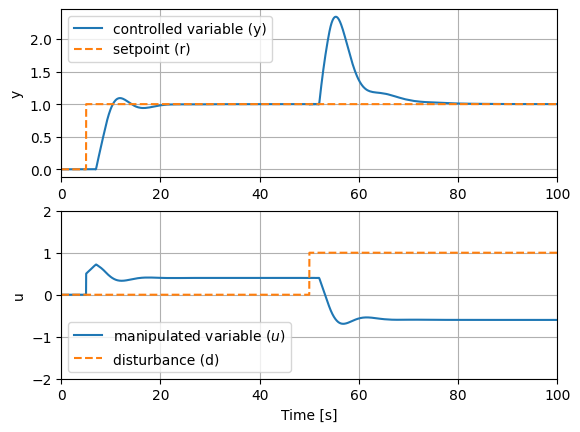



********************* LLM Tuning *********************
Controller type: PI
Generate examples:


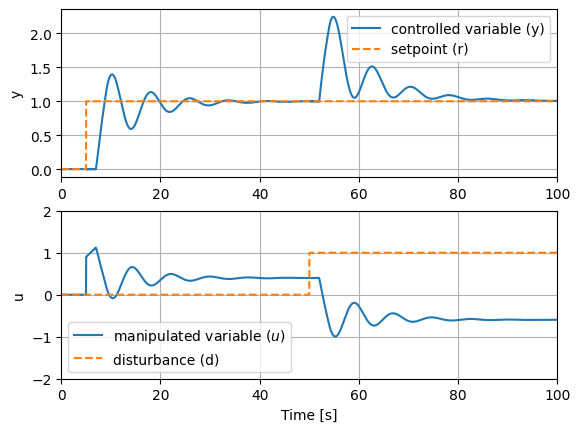

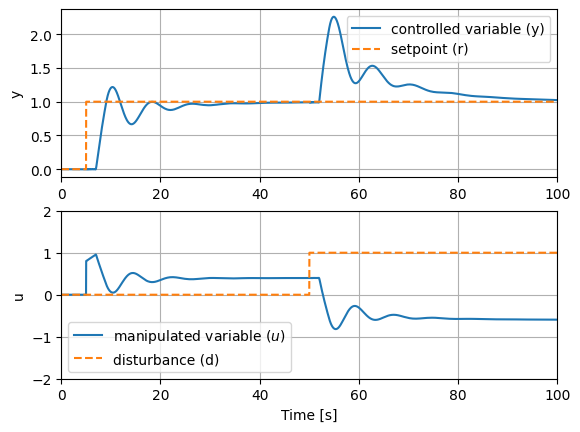



Gemini is prompted
Initiation prompt response:
* new tuning parameters (Kc, tau_I): (0.95, 7.5)
* A slight increase in Kc and decrease in tau_I is proposed, as the move from (0.8, 10) to (0.9, 8) significantly reduced MSE, suggesting that a slightly more aggressive controller might yield further improvements.
iteration 0: Kc = 0.95, tau_I = 7.5, mse = 0.08826224058410115, y_var = 0.09046761241043637, u_var = 0.2886256945252841


Iteration 0 response:
* new tuning parameters (Kc, tau_I): (0.89, 8.1)
* The previous iteration (0.95, 7.5) resulted in a slightly higher MSE and increased variances compared to (0.9, 8), indicating that a slightly less aggressive controller (lower Kc, higher tau_I) might be beneficial for minimizing MSE and improving variances.
iteration 1: Kc = 0.89, tau_I = 8.1, mse = 0.08831375490889025, y_var = 0.0897485582349014, u_var = 0.27054759745782214


Iteration 1 response:
* new tuning parameters (Kc, tau_I): (0.895, 8.05)
* A slight increase in Kc and decrease 

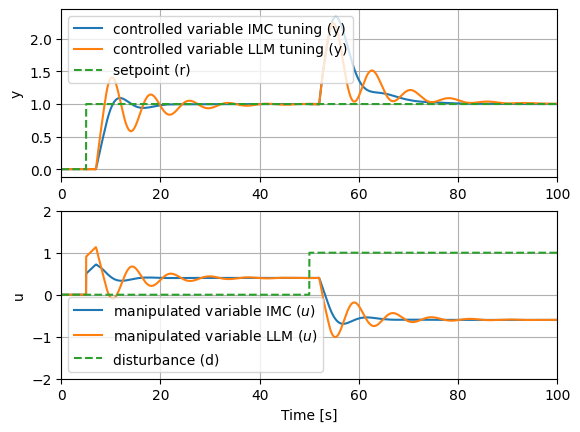

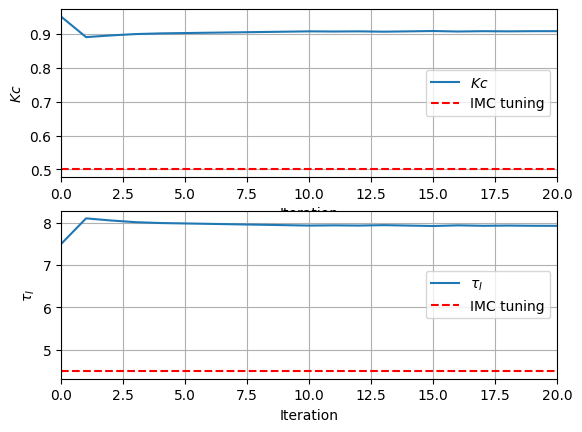

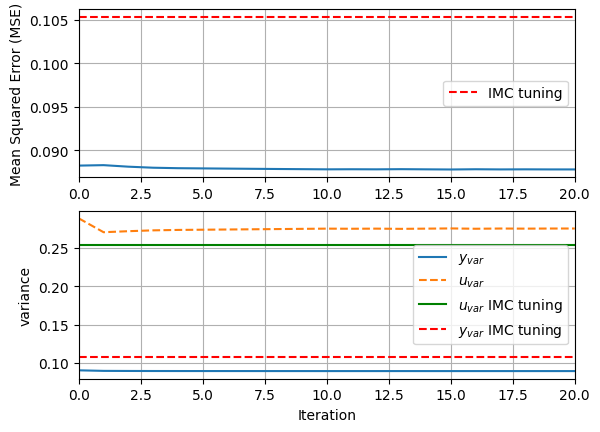

********************* Baseline: IMC Tuning *********************
IMC params: [('Kc', 0.391304347826087), ('tau_I', 4.5), ('tau_D', 0.7777777777777778)]


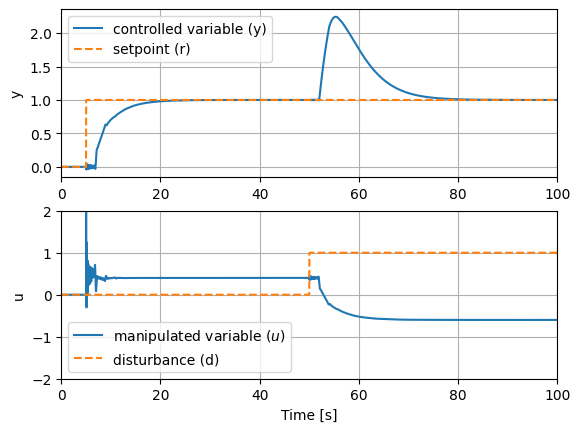



********************* LLM Tuning *********************
Controller type: PID
Generate examples:


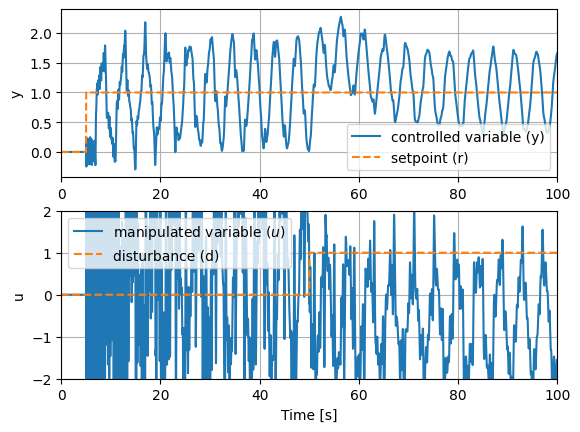

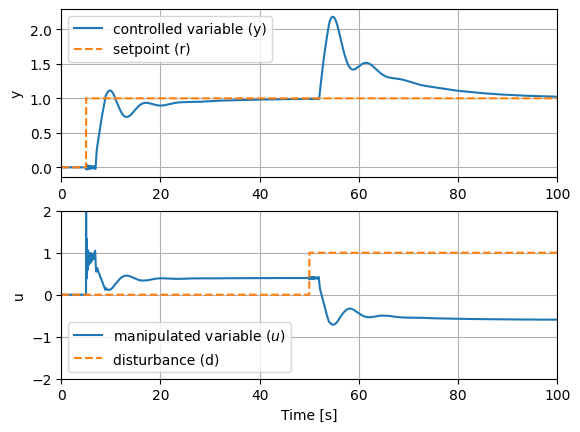



Gemini is prompted
Initiation prompt response:
*   new tuning parameters (Kc, tau_I, tau_D) aiming to minimize the mean square error: (0.75, 12, 0.25)
*   This choice continues to reduce controller aggressiveness (Kc, tau_D) and slow integral action (tau_I), following the trend that significantly improved MSE and reduced variance in the previous step.
iteration 0: Kc = 0.75, tau_I = 12.0, tau_D = 0.25, mse = 0.11070978671188793, y_var = 0.10800345475933457, u_var = 0.23495521737866348


Iteration 0 response:
*   new tuning parameters (Kc, tau_I, tau_D) aiming to minimize the mean square error: (0.78, 10.5, 0.28)
*   The previous iteration showed an increase in MSE, suggesting the optimal parameters might be closer to the values from Example 2; therefore, this choice slightly adjusts Kc and tau_D upwards and tau_I downwards, moving closer to the best performing parameters found so far.
iteration 1: Kc = 0.78, tau_I = 10.5, tau_D = 0.28, mse = 0.09793050299381333, y_var = 0.09656913797

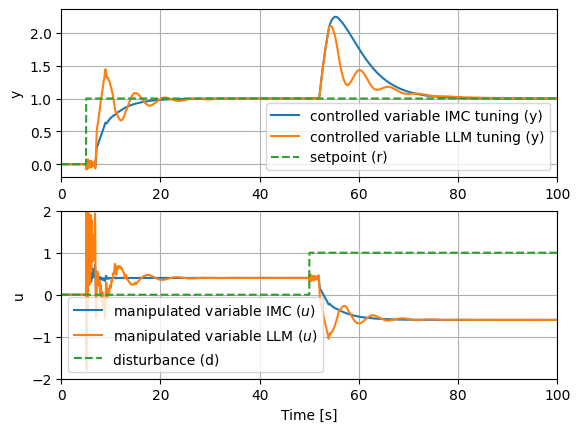

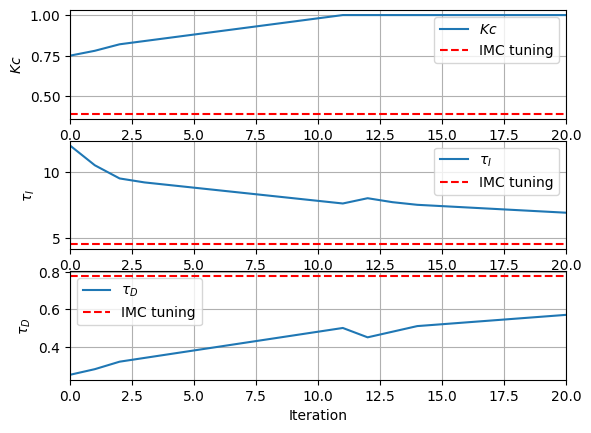

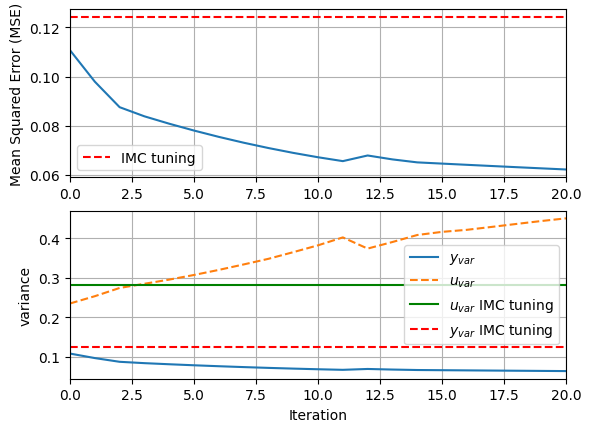

********************* Baseline: IMC Tuning *********************
IMC params: [('Kc', 0.32142857142857145), ('tau_I', 4.5), ('tau_D', 0.7777777777777778), ('tau_F', 0.6428571428571429)]


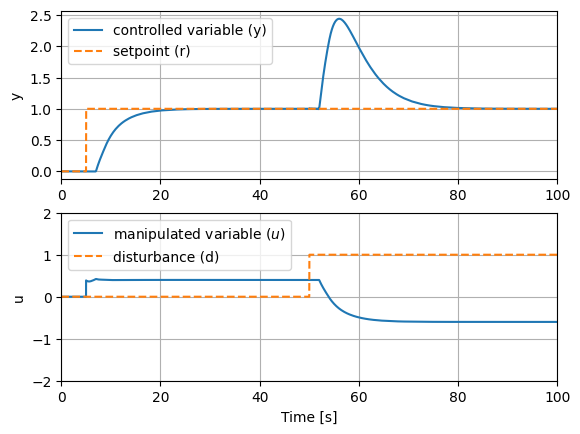



********************* LLM Tuning *********************
Controller type: PIDwfilter
Generate examples:


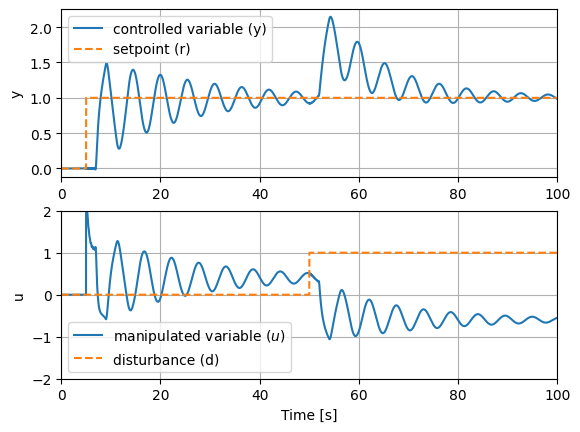

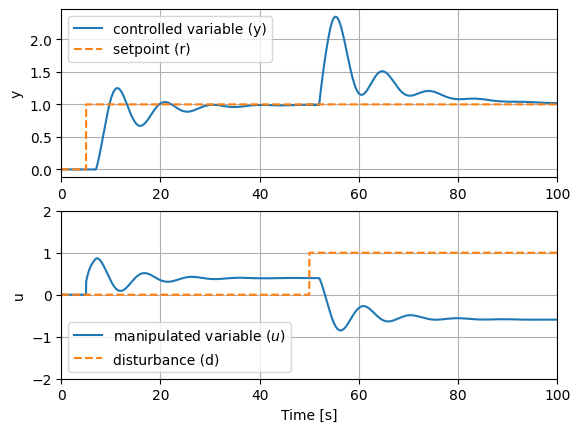



Gemini is prompted
Initiation prompt response:
* new tuning parameters (0.85, 7, 1.0, 0.7) aiming to minimize the mean square error.
* This set of parameters slightly reduces the proportional and derivative gains from the best-performing example while increasing the derivative filter time constant to mitigate manipulated variable variance, aiming to maintain low MSE with a slightly more aggressive integral action.
iteration 0: Kc = 0.85, tau_I = 7.0, tau_D = 1.0, tau_F = 0.7, mse = 0.07950496088294925, y_var = 0.08099679128508532, u_var = 0.26625224875882675


Iteration 0 response:
* new tuning parameters (0.88, 6.8, 1.1, 0.8) aiming to minimize the mean square error.
* This set slightly increases the proportional and derivative gains and makes the integral action marginally more aggressive to potentially lower MSE, while a further increased derivative filter aims to mitigate manipulated variable variance.
iteration 1: Kc = 0.88, tau_I = 6.8, tau_D = 1.1, tau_F = 0.8, mse = 0.0779027

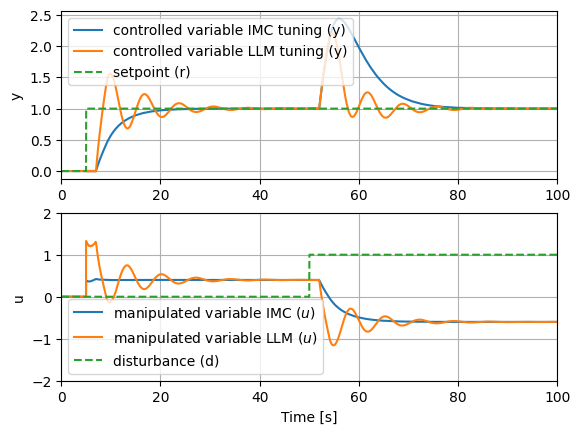

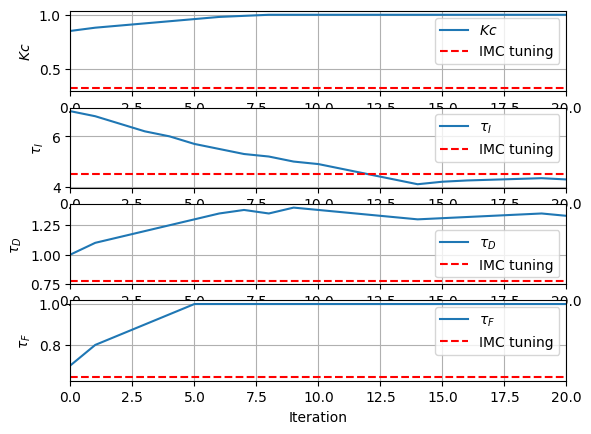

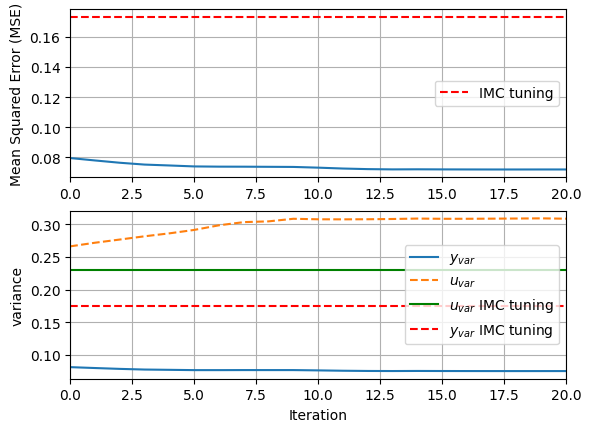

In [ ]:
#@title **Run All Experiments**
if __name__ == "__main__":
    # Set up environment and random seed
    env_file_path = "keys.env"
    pwd = os.path.dirname(os.getcwd())
    env_file_path = os.path.abspath(os.path.join(pwd, env_file_path))
    np.random.seed(20)
    float_formatter = "{:.3f}".format
    np.set_printoptions(formatter={'float_kind': float_formatter})

    # Common plant and simulation parameters
    kp = 2.5
    tau = 3.5
    theta = 2
    alpha = 0.8
    t_start = 0
    t_end = 100
    n_samples = 10000
    t_setpoint = 5
    setpoint = 1
    t_disturbance = 50
    disturbance = 1

    # Run for PI, PID, PIDwfilter
    evaluations = []
    chat_history = {}
    for case, max_iterations in zip([1, 2, 3], [20, 20, 20]):
        run_experiment(case, alpha, tau, theta, kp, t_start, t_end, n_samples, t_setpoint, setpoint, t_disturbance, disturbance, max_iterations)


## **Summary**

This demonstration illustrates how Large Language Models, utilizing an in-context learning framework, can perform iterative numerical optimization of PID controller parameters using only execution traces and performance feedback embedded within the prompt. By presenting the LLM with a small set of initial tuning parameter combinations and their corresponding closed-loop performance metrics (MSE, output variance, and manipulated variable variance), the model is encouraged to infer underlying parameter-performance relationships and propose improved values over time—without being given the process model equations or classical tuning rules. Each iteration provides updated context from actual simulation outcomes, allowing the LLM to adjust its recommendations and progressively refine controller performance through pattern recognition rather than explicit gradient computation, effectively taking on the role of a **control systems engineering assistant**.

We purposely refrain from passing the true model parameters ($k_p$, $\tau$, $\theta$) to the LLM in our prompt, ensuring that the tuning parameters result purely from iterative conversational interactions, rather than leveraging nascent knowledge of classical control theory. Through this setup, we observe how the LLM implicitly constructs a "textual gradient," behaving as an optimizer driven by linguistic reasoning and contextual feedback.

Our results show that the LLM-tuned PID controller achieves **performance comparable to the well-established IMC method**, and in some configurations even surpasses it based on the provided quantitative metrics. However, as control systems engineers recognize, MSE and variance represent only a subset of closed-loop performance criteria. **Oscillatory behavior, rise time, settling time, robustness margins, and other temporal characteristics** are equally critical depending on the application. This work demonstrates the LLM's capability to optimize multi-objective problems, a flexibility that can be extended to incorporate these additional criteria as needed.

**Future Directions:** Beyond this PID tuning example, we plan to explore the generalizability of this approach to a broader range of control systems engineering challenges. By leveraging the multimodal capabilities of modern LLMs—embedding closed-loop step responses, frequency-domain characteristics, or constraint violations directly within the prompt as plots or data traces—we believe LLMs can be guided to refine controller parameters, adapt to process changes, or even suggest structural modifications for cascade and multivariable systems. These extensions would further highlight the flexibility of in-context learning for enabling self-improvement loops in control engineering.

## **Conclusion**

This tutorial demonstrates that LLMs can act as effective, gradient-free numerical optimizers for PID controller tuning using only the information supplied in the prompt—capturing the core idea of in-context learning in a classical control systems setting. Without receiving process model parameters, analytical derivatives, or traditional tuning methodologies, the LLM learns from the pattern of tuning parameters and their measured performance to generate increasingly effective PID settings over successive iterations. While the LLM is not performing true dynamic simulation internally, its ability to discover improved controller parameters purely from contextual feedback validates a key insight: **LLMs can acting as an optimizer and drive classical controllers fine-tuning through structured conversational prompting alone, taking the role of an control systems engineering assistant**.

Our implementation successfully tunes PI, PID, and PIDwF controllers for a first-order system with delay, achieving performance that can be quantitatively compared against the established IMC baseline. The preservation of complete conversation transcripts—including the LLM's one-sentence reasoning at each iteration—provides an unprecedented level of **explainability in automated controller tuning**. This work demonstrates a practical and interpretable pathway for integrating LLMs into control engineering workflows, where language becomes the substrate for iterative design refinement and knowledge transfer from simulation to actionable tuning recommendations. By refraining from providing the LLM with underlying model parameters, we validate that the optimization emerges genuinely from the conversational interaction, rather than pre-existing control theory memorization—representing a true advancement in AI-assisted control systems engineering.

## **References**

Rivera, D. E., Morari, M., & Skogestad, S. (1986). Internal model control: PID controller design. Industrial & engineering chemistry process design and development, 25(1), 252-265.